CSI-5140 Machine Learning
David Bruce
Oakland University
December 2, 2024

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import cross_val_score, cross_validate

data = pd.read_csv('data3.csv')
data.info()
print(sklearn.__version__)
df_numeric = data.drop(columns=['Date'])
#correlation_matrix = df_numeric.corr()
#print(correlation_matrix)

corr = df_numeric.corr()
# Use the format method to set precision
corr_styled = corr.style.background_gradient(cmap='coolwarm').format(precision=2)

# Display the styled DataFrame
corr_styled



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 184 non-null    object 
 1   Resting Heart Rate   184 non-null    float64
 2   Sleep deepAvg7       184 non-null    int64  
 3   Sleep BPMAvg7        184 non-null    float64
 4   sleepHRVAvg7         184 non-null    int64  
 5   CyclingMinutesAvg7   184 non-null    float64
 6   StrengthMinutesAvg7  184 non-null    float64
 7   ActCalsAvg7          184 non-null    float64
 8   VO2Max               184 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 13.1+ KB
1.4.2


,Resting Heart Rate,Sleep deepAvg7,Sleep BPMAvg7,sleepHRVAvg7,CyclingMinutesAvg7,StrengthMinutesAvg7,ActCalsAvg7,VO2Max
Resting Heart Rate,1.00,0.11,0.04,-0.12,-0.26,0.09,-0.15,0.37
Sleep deepAvg7,0.11,1.00,-0.35,0.14,0.22,0.24,0.21,0.15
Sleep BPMAvg7,0.04,-0.35,1.00,-0.54,-0.26,-0.23,-0.07,-0.47
sleepHRVAvg7,-0.12,0.14,-0.54,1.00,0.17,0.03,0.00,0.31
CyclingMinutesAvg7,-0.26,0.22,-0.26,0.17,1.00,0.07,0.28,-0.03
StrengthMinutesAvg7,0.09,0.24,-0.23,0.03,0.07,1.00,0.07,-0.00
ActCalsAvg7,-0.15,0.21,-0.07,0.00,0.28,0.07,1.00,-0.28
VO2Max,0.37,0.15,-0.47,0.31,-0.03,-0.00,-0.28,1.00


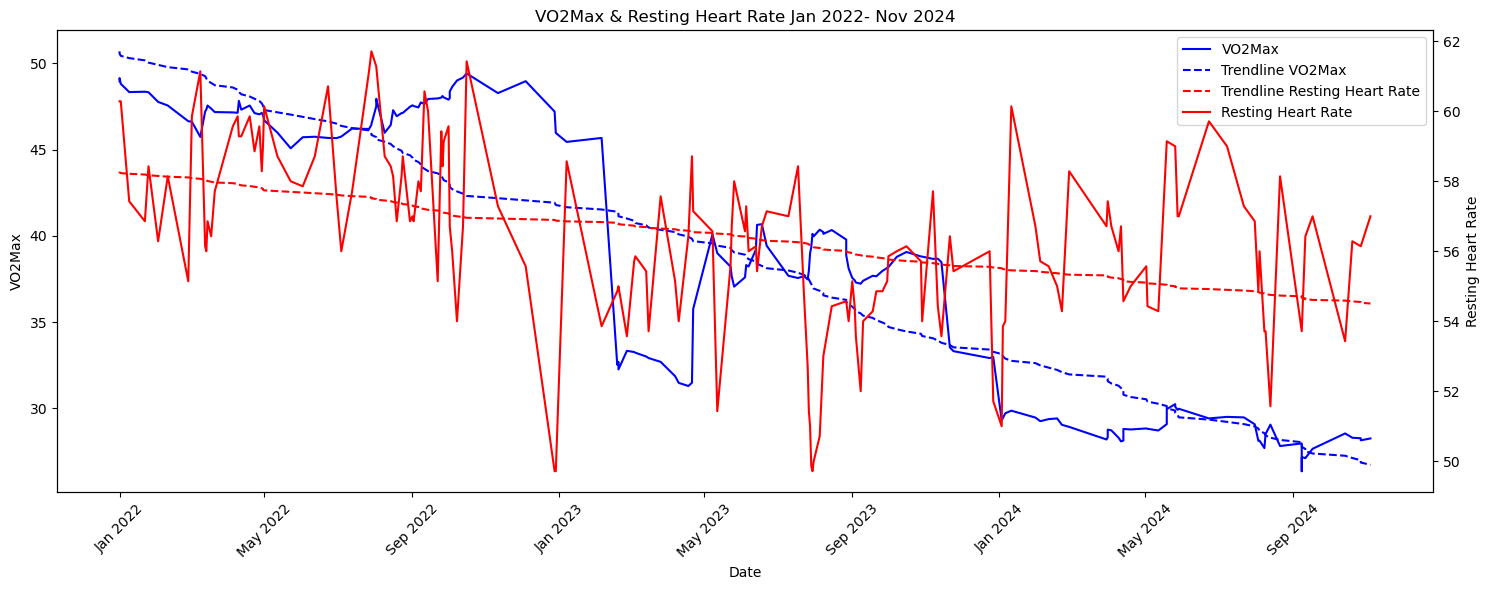

In [15]:
data['Date'] = pd.to_datetime(data['Date'])
# Plot data
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(data['Date'], data['VO2Max'], label='VO2Max', color='blue')

# Format the X-axis to show dates nicely
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format the ticks to show abbreviated month and full year

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Add trendlines
z1 = np.polyfit(data.index, data['VO2Max'], 1)
p1 = np.poly1d(z1)
ax1.plot(data['Date'], p1(data.index), color='blue', linestyle='--', label='Trendline VO2Max')
ax1.set_xlabel('Date')
ax1.set_ylabel('VO2Max')

z2 = np.polyfit(data.index, data['Resting Heart Rate'], 1)
p2 = np.poly1d(z2)
ax2 = ax1.twinx()
ax2.set_ylabel('Resting Heart Rate')
ax2.plot(data['Date'], p2(data.index), color='red', linestyle='--', label='Trendline Resting Heart Rate')
ax2.plot(data['Date'], data['Resting Heart Rate'], label='Resting Heart Rate', color='red')

# Add legends for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

plt.title('VO2Max & Resting Heart Rate Jan 2022- Nov 2024')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [3]:
results = pd.DataFrame(columns=['Model', 'MAE', 'Cross-Val NMAE'])

# Function to add results to the DataFrame
def add_results(results, model_name, mae, mscores):
    new_row = pd.DataFrame({'Model': [model_name], 'MAE': [mae], 'Cross-Val NMAE': [mscores]})
    if results.empty:
        return new_row
    else:
        return pd.concat([results, new_row], ignore_index=True)


X = data.drop(columns=['VO2Max', 'Date'])
y = data["VO2Max"]

features = ['Resting Heart Rate', 'Sleep deepAvg7', 'Sleep BPMAvg7', 'sleepHRVAvg7', 'CyclingMinutesAvg7', 'StrengthMinutesAvg7', 'ActCalsAvg7']

feature_scaler = StandardScaler()
X = feature_scaler.fit_transform(data[features].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Ridge Regression
ridge_reg = Ridge(alpha=1.0)  # You can adjust the alpha parameter for regularization strength
ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(ridge_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
results = add_results(results, 'Ridge Regression', mae, -scores.mean())

#Lasso Regression
# Initialize and train the Lasso regression model
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = lasso_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(lasso_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
results = add_results(results, 'Lasso Regression', mae, -scores.mean())

# Initialize and train the ElasticNet regression model
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = elastic_net.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(elastic_net, X, y, cv=5, scoring='neg_mean_absolute_error')
results = add_results(results, 'Elastic_Net Regression', mae, -scores.mean())

# Initialize and train the Bayesian Ridge regression model
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = bayesian_ridge.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(bayesian_ridge, X, y, cv=5, scoring='neg_mean_absolute_error')
results = add_results(results, 'Bayesian Regression', mae, -scores.mean())


In [5]:

pipeline = make_pipeline(StandardScaler(), SVR())

param_grid = {
    'svr__C': [0.1, 1, 10, 100, 1000, 10000],
    'svr__epsilon': [0.01, 0.1, 1],
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error')
results = add_results(results, 'SVM Regression', mae, -scores.mean())


In [7]:
print(best_params)

{'svr__C': 1, 'svr__epsilon': 1, 'svr__kernel': 'linear'}


In [9]:
# Initialize and train the Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = tree_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(tree_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
results = add_results(results, 'Decision Tree Regressor', mae, -scores.mean())

# Initialize and train the Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(rf_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
results = add_results(results, 'Random Forest Regressor', mae, -scores.mean())

# Initialize and train the Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_reg.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = gb_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(gb_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
results = add_results(results, 'Gradient Boosting Regressor', mae, -scores.mean())

# Initialize and train the K-Nearest Neighbors Regressor
knn_reg = KNeighborsRegressor(n_neighbors=3)
knn_reg.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = knn_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(gb_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
results = add_results(results, 'K-Nearest Neighbors Regressor', mae, -scores.mean())


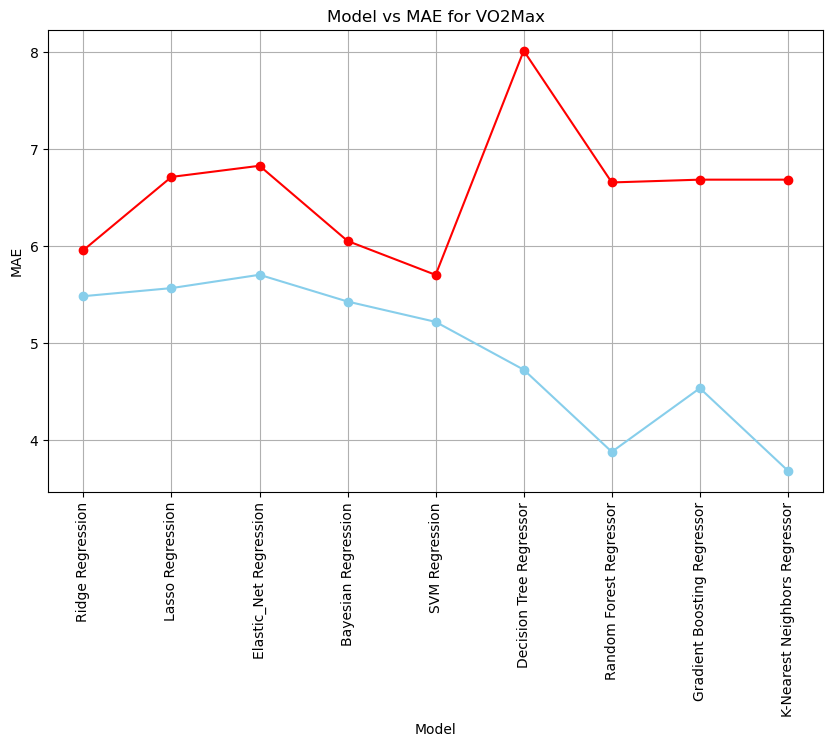

                           Model       MAE  Cross-Val NMAE
0               Ridge Regression  5.480006        5.954838
1               Lasso Regression  5.563367        6.710244
2         Elastic_Net Regression  5.700799        6.825185
3            Bayesian Regression  5.424748        6.049487
4                 SVM Regression  5.214913        5.699602
5        Decision Tree Regressor  4.721622        8.011995
6        Random Forest Regressor  3.874419        6.653240
7    Gradient Boosting Regressor  4.530862        6.682018
8  K-Nearest Neighbors Regressor  3.679640        6.682018


In [29]:
# Plotting
plt.figure(figsize=(10, 6))
line1 = plt.plot(results['Model'], results['MAE'], marker='o', linestyle='-', color='skyblue')
line2 = plt.plot(results['Model'], results['Cross-Val NMAE'], marker='o', linestyle='-', color='red')
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model vs MAE for VO2Max')
plt.grid(True)
plt.show()
print(results)
results.to_csv('VO2Max Results.csv', index=False)